In [0]:
import matplotlib
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
import sklearn.pipeline
import sklearn.preprocessing

env = gym.make('MountainCar-v0')

In [0]:
num_episodes = 200

discount_factor = 1.0

alpha = 0.01
nA = env.action_space.n

w = np.zeros((nA,400))


plt_actions = np.zeros(nA)

episode_rewards = np.zeros(num_episodes)



observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

In [3]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)


featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
		])


featurizer.fit(scaler.transform(observation_examples))



FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [0]:

def featurize_state(state):

	scaled = scaler.transform([state])
	featurized = featurizer.transform(scaled)
	return featurized

In [0]:
def Q(state,action,w):
	value = state.dot(w[action])
	return value


In [0]:

def policy(state, weight, epsilon=0.1):
	A = np.ones(nA,dtype=float) * epsilon/nA
	best_action =  np.argmax([Q(state,a,w) for a in range(nA)])
	A[best_action] += (1.0-epsilon)
	sample = np.random.choice(nA,p=A)
	return sample


In [0]:

def check_gradients(index,state,next_state,next_action,weight,reward):

	ew1 = np.array(weight, copy=True) 
	ew2 = np.array(weight, copy=True)  
 
	epsilon = 1e-6
	ew1[action][index] += epsilon
	ew2[action][index] -= epsilon
	
	test_target_1 = reward + discount_factor * Q(next_state,next_action,ew1)		
	td_error_1 = target - Q(state,action,ew1)

	test_target_2 = reward + discount_factor * Q(next_state,next_action,ew2)		
	td_error_2 = target - Q(state,action,ew2)

	grad = (td_error_1 - td_error_2) / (2 * epsilon)
	
	return grad[0]


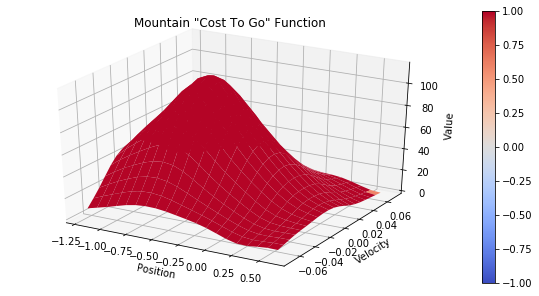

In [8]:

for e in range(num_episodes):

	state = env.reset()
	state = featurize_state(state)

	while True:	
		action = policy(state,w)	
		plt_actions[action] += 1
		next_state, reward, done, _ = env.step(action)
		next_state = featurize_state(next_state)
		next_action = policy(next_state,w)
		episode_rewards[e] += reward
		target = reward + discount_factor * Q(next_state,next_action,w)		
		td_error = Q(state,action,w) - target
		dw = (td_error).dot(state)
		w[action] -= alpha * dw

		if done:
			break
		
		state = next_state

def plot_cost_to_go_mountain_car(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([Q(featurize_state(_),a,w) for a in range(nA)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


plot_cost_to_go_mountain_car()

env.close()